# Homework 5

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, homogeneity_score, completeness_score, v_measure_score
from scipy.cluster.hierarchy import dendrogram, linkage

In this assignment, we'll be using the MNIST dataset to practice using dimensionality reduction and clustering with data. The MNIST dataset consists of 70,000 handwritten images of integers, and is often used for introductory image recognition training. Dimensionality reduction can be useful to counteract the "curse of dimensionality", which can cause models that are fit to data in high dimensions to overfit and not correctly map to new data points. Clustering is a machine learning algorithm that fits under the umbrella of unsupervised learning; unsupervised learning is less powerful than supervised learning, generally speaking, but doesn't require the data to already be labeled. Since the MNIST data comes with labels, the exercises in clustering will primarily be to practice using clustering algorithms.

 I'll start by reading in the MNIST data and rescaling it from 0-255 to 0-1:

In [2]:
mnist = fetch_mldata("MNIST original")
X = mnist.data / 255.0
y = mnist.target

To make sure everything's been read in correctly, I'll make sure the data's in the form I expect and check the value counts for each integer in MNIST. I'll also show one of the images.

In [3]:
print(X.shape, y.shape)

(70000, 784) (70000,)


In [4]:
pd.Series(y).value_counts()

1.0    7877
7.0    7293
3.0    7141
2.0    6990
9.0    6958
0.0    6903
6.0    6876
8.0    6825
4.0    6824
5.0    6313
dtype: int64

([], <a list of 0 Text yticklabel objects>)

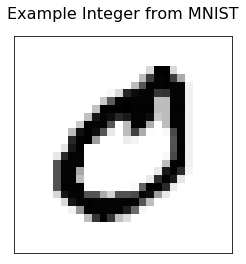

In [5]:
plt.imshow(X[1].reshape((28,28)), cmap='Greys')
plt.title("Example Integer from MNIST", size=16, y=1.05)
plt.xticks([])
plt.yticks([])

Value counts for each of the integers are between 6000 and 8000, giving us a high number of data points for every integer. Similarly, the X and y matrices were the size we expected, and we were able to correctly plot an image from the dataset, so everything seems to be working properly!

### 1) PCA

PCA is an algorithm we'll be using to reduce the dimensionality of the MNIST data. The goal will be to minimize the number of components included, while still keeping the explained variance ratio high, with the goal of attempting to group integers in the MNIST dataset using the least number of components. Reducing the dimensionality to two is particularly useful, since it allows for the plotting of the components in clusters in a 2 dimensional chart.

#### a) Number of Components

In order to find a good number of components to use for PCA, I'll chart the first few hundred components that most contribute to variance between the integers, and plot the total explained variance by all components up to that one. By identifying where the added benefit of each component begins to tail off, I'll find a reasonable number of components to use.

In [6]:
pca = PCA(n_components=250)
X_pca = pca.fit_transform(X)
cum_ratio = np.cumsum(pca.explained_variance_ratio_)

Text(0.5,1.05,'Explained Variance')

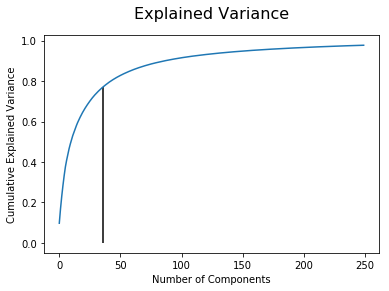

In [7]:
plt.plot(range(len(cum_ratio)), cum_ratio)
plt.vlines(ymin=0,ymax=cum_ratio[36],x=36)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance', size=16, y=1.05)

36 components seems to be a reasonable number of components to use. Beyond 36, each added component starts contributing quite a bit less, and while it's not quite at the "elbow", I think it should work pretty well. For showing image compressions later, I'll do a PCA using 36, 100, and 225 components.

In [8]:
print("36 components:", cum_ratio[36])
print("100 components:", cum_ratio[100])
print("225 components:", cum_ratio[225])

36 components: 0.772662173258
100 components: 0.915943343104
225 components: 0.973034929199


36 components accounts for 77% of the variance, 100 for 92%, and 225 for 97%. Not bad, considering we're only using a small fraction of the total components (784)!

Transforming the data to 36, 100, and 225 components, then inverse transforming to return the images to their original size for plotting:

In [9]:
pca36 = PCA(n_components=36)
X_pca36 = pca36.fit_transform(X)
X_pca36 = pca36.inverse_transform(X_pca36)

pca100 = PCA(n_components=100)
X_pca100 = pca100.fit_transform(X)
X_pca100 = pca100.inverse_transform(X_pca100)

pca225 = PCA(n_components=225)
X_pca225 = pca225.fit_transform(X)
X_pca225 = pca225.inverse_transform(X_pca225)

#### b) Plot 2 components using PCA

By using only 2 of the components, we can use PCA to attempt to look for clusters in our data:

In [10]:
pca2 = PCA(n_components=2)
X_pca2 = pca2.fit_transform(X)

In [11]:
df_pca = pd.DataFrame(X_pca2, columns=['comp1','comp2'])
df_pca['label'] = y
df_pca = df_pca.sample(n=7000)

Text(0.5,1.05,'PCA, 2 Component Clusters')

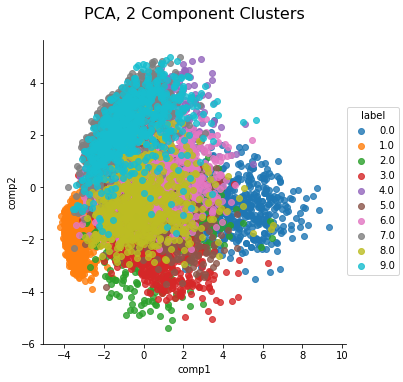

In [12]:
sns.lmplot(x='comp1', y='comp2', data=df_pca, hue='label', fit_reg=False)
plt.title("PCA, 2 Component Clusters", size=16, y=1.05)

#### c) Why use PCA?

PCA is useful for identifying the components that are most useful, and for avoiding the curse of dimensionality, which can cause models to overfit when trained on data that has extremely high dimensionality. In this example, PCA is being used to identify the areas of the image that provide the most information, and then being used to compress the images, storing only the most important information. PCA's primary drawback is that it can't be as precise as the full dimensions; above, for example, PCA with 225 components captured 97% of the variance in the original data, but still lost 3% of the variance. The fewer the components used, the more of the variance you'll end up giving up by using PCA.

#### d) Compressing Images with PCA

Here I show each of the images, then compare them with three compressed versions of the same image.

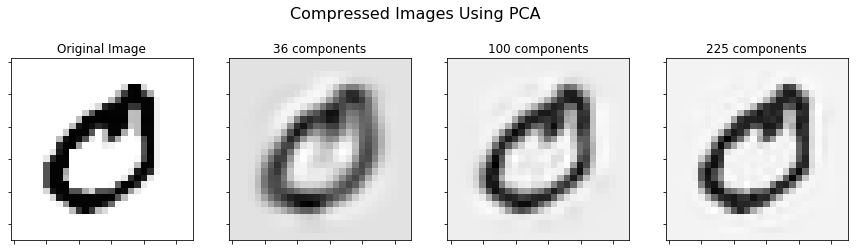

In [13]:
fig, axes = plt.subplots(1, 4, figsize=(15,5))

fig.suptitle('Compressed Images Using PCA', fontsize=16, y=0.9)

axes[0].imshow(X[1].reshape((28,28)), cmap='Greys')
axes[1].imshow(X_pca36[1].reshape((28,28)), cmap='Greys')
axes[2].imshow(X_pca100[1].reshape((28,28)), cmap='Greys')
axes[3].imshow(X_pca225[1].reshape((28,28)), cmap='Greys')

axes[0].set_title("Original Image")
axes[1].set_title("36 components")
axes[2].set_title("100 components")
axes[3].set_title("225 components")

for i in range(0,4):
    axes[i].xaxis.set_ticklabels([])
    axes[i].yaxis.set_ticklabels([])

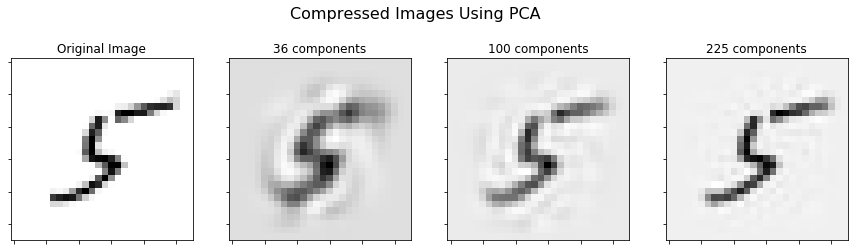

In [14]:
fig, axes = plt.subplots(1, 4, figsize=(15,5))

fig.suptitle('Compressed Images Using PCA', fontsize=16, y=0.9)

axes[0].imshow(X[35000].reshape((28,28)), cmap='Greys')
axes[1].imshow(X_pca36[35000].reshape((28,28)), cmap='Greys')
axes[2].imshow(X_pca100[35000].reshape((28,28)), cmap='Greys')
axes[3].imshow(X_pca225[35000].reshape((28,28)), cmap='Greys')

axes[0].set_title("Original Image")
axes[1].set_title("36 components")
axes[2].set_title("100 components")
axes[3].set_title("225 components")

for i in range(0,4):
    axes[i].xaxis.set_ticklabels([])
    axes[i].yaxis.set_ticklabels([])

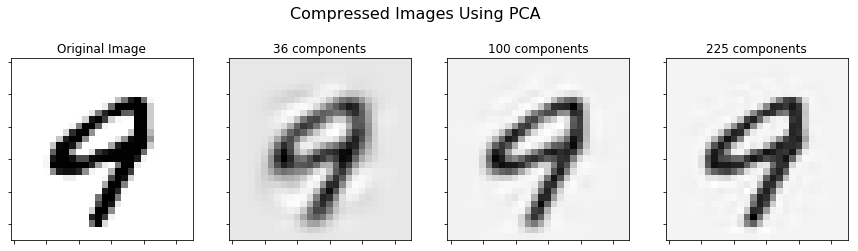

In [15]:
fig, axes = plt.subplots(1, 4, figsize=(15,5))

fig.suptitle('Compressed Images Using PCA', fontsize=16, y=0.9)

axes[0].imshow(X[69999].reshape((28,28)), cmap='Greys')
axes[1].imshow(X_pca36[69999].reshape((28,28)), cmap='Greys')
axes[2].imshow(X_pca100[69999].reshape((28,28)), cmap='Greys')
axes[3].imshow(X_pca225[69999].reshape((28,28)), cmap='Greys')

axes[0].set_title("Original Image")
axes[1].set_title("36 components")
axes[2].set_title("100 components")
axes[3].set_title("225 components")

for i in range(0,4):
    axes[i].xaxis.set_ticklabels([])
    axes[i].yaxis.set_ticklabels([])

Not bad! Even with only 36 components, the integers are still mostly readable, even though 36 components represents only a tiny fraction of the dimensions we started with. By using PCA to reduce the size of the images to 36, we can effectively reduce the data we'd train a model on, speeding up the training process.

### 2) t-SNE

T-SNE is a slightly different dimensionality reduction technique from PCA. While PCA attempts to find the most relevant components and can be used for data preprocessing for models, t-SNE is used primarily to visualize clusters in the data. I'll be using t-SNE here to reduce the dimensionality of the data down to 2 so I can then plot the data in 2 dimensions and visualize the clusters a bit better. Since t-SNE is slow on large data sets, I'll randomly choose a selection of rows from the full MNIST data to run it over. (I tried using a selection of 10000 rows for this, but it ran really, really slowly. Given the number of times I run t-SNE, I decided to use 5000 rows instead, to reduce the notebooks runtime.)

In [16]:
rows = np.arange(70000)
np.random.shuffle(rows)

tsne50 = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=1000, learning_rate=200)
tsne50_results = tsne50.fit_transform(X_pca36[rows[:5000],:])

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.116s...
[t-SNE] Computed neighbors for 5000 samples in 39.786s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 2.008284
[t-SNE] KL divergence after 250 iterations with early exaggeration: 77.850189
[t-SNE] Error after 1000 iterations: 1.379584


In [17]:
df_tsne50 = pd.DataFrame(tsne50_results, columns=['comp1', 'comp2'])
df_tsne50['label'] = y[rows[:5000]]

Text(0.5,1.05,'t-SNE Clustering')

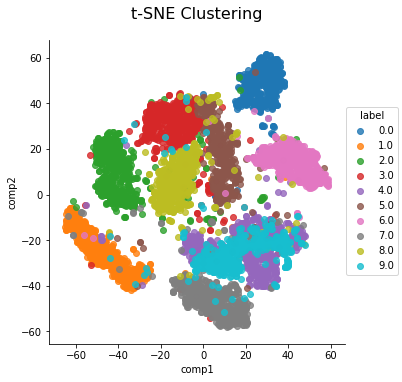

In [18]:
sns.lmplot(x='comp1', y='comp2', data=df_tsne50, hue='label', fit_reg=False)
plt.title("t-SNE Clustering", size=16, y=1.05)

#### a) t-SNE vs PCA

The t-SNE plot is extremely different from the PCA plot. While both reduce the dimensionality of the data to 2, the t-SNE plot more clearly shows groupings and clustering in the data, while the PCA plot had most of the different integers piled over each other. This highlights t-SNE's primary advantage: dimensionality reduction for visualization. While it hasn't perfectly separated out each of the different integers, it's done a pretty fair job.

#### b) Changes in Perplexity

Perplexity is a hyperparameter taken by t-SNE that can have a pretty large impact on how the algorithm works. A perplexity between 5 and 50 is recommended, and since I already tried 50, I'll try 5 at the opposite extreme and 30 as a value right in the middle and see how they compare to the previous t-SNE I ran.

In [19]:
tsne5 = TSNE(n_components=2, verbose=1, perplexity=5, n_iter=1000, learning_rate=200)
tsne5_results = tsne5.fit_transform(X_pca36[rows[:5000],:])

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.106s...
[t-SNE] Computed neighbors for 5000 samples in 38.577s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 1.101767
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.563072
[t-SNE] Error after 1000 iterations: 1.526733


In [20]:
df_tsne5 = pd.DataFrame(tsne5_results, columns=['comp1', 'comp2'])
df_tsne5['label'] = y[rows[:5000]]

Text(0.5,1.05,'t-SNE, 5 Perplexity')

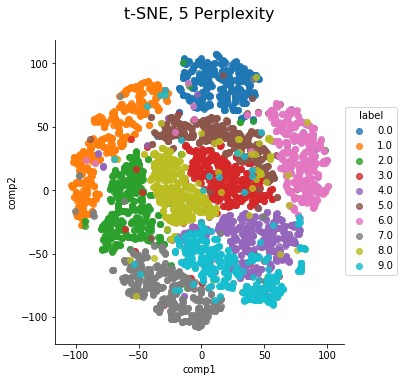

In [21]:
sns.lmplot(x='comp1', y='comp2', data=df_tsne5, hue='label', fit_reg=False)
plt.title("t-SNE, 5 Perplexity", size=16, y=1.05)

In [22]:
tsne30 = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=1000, learning_rate=200)
tsne30_results = tsne30.fit_transform(X_pca36[rows[:5000],:])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.131s...
[t-SNE] Computed neighbors for 5000 samples in 39.612s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 1.797164
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.971375
[t-SNE] Error after 1000 iterations: 1.460828


In [23]:
df_tsne30 = pd.DataFrame(tsne30_results, columns=['comp1', 'comp2'])
df_tsne30['label'] = y[rows[:5000]]

Text(0.5,1.05,'t-SNE, 30 Perplexity')

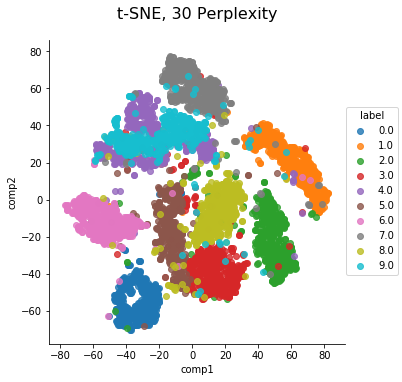

In [24]:
sns.lmplot(x='comp1', y='comp2', data=df_tsne30, hue='label', fit_reg=False)
plt.title("t-SNE, 30 Perplexity", size=16, y=1.05)

A perplexity level of 5 seems to work best. While none of the charts differ too substantially from the others and all get a lot of points wrong, 5 perplexity seemed to mix up 4's and 9's the least, so I'll use it going here. T-SNE isn't super robust to perplexity; changes in perplexity can change the results pretty enormously.

#### c) Changes in Learning Rate and Number of Iterations

Here I'll be experimenting with different learning rates and number of iterations, both hyperparameters taken by t-SNE. Since a perplexity level of 5 seemed to work best, I'll stick with that and alter first the learning rate, then the number of iterations and see what impact that has. I'll start by trying learning rates both higher (300) and lower (100) than what I initially used.

In [25]:
tsne5lr100 = TSNE(n_components=2, verbose=1, perplexity=5, n_iter=1000, learning_rate=100)
tsne5lr100_results = tsne5lr100.fit_transform(X_pca36[rows[:5000],:])

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.127s...
[t-SNE] Computed neighbors for 5000 samples in 39.428s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 1.101767
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.607414
[t-SNE] Error after 1000 iterations: 1.556911


In [26]:
df_tsne5lr100 = pd.DataFrame(tsne5lr100_results, columns=['comp1', 'comp2'])
df_tsne5lr100['label'] = y[rows[:5000]]

Text(0.5,1.05,'t-SNE, Learning Rate 100')

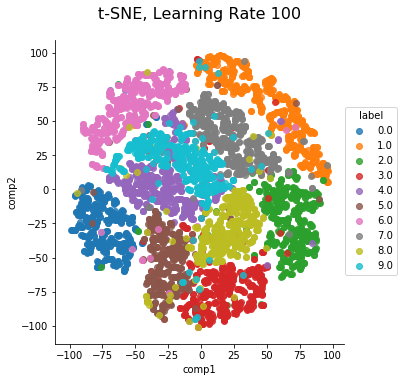

In [27]:
sns.lmplot(x='comp1', y='comp2', data=df_tsne5lr100, hue='label', fit_reg=False)
plt.title("t-SNE, Learning Rate 100", size=16, y=1.05)

In [28]:
tsne5lr300 = TSNE(n_components=2, verbose=1, perplexity=5, n_iter=1000, learning_rate=300)
tsne5lr300_results = tsne5lr300.fit_transform(X_pca36[rows[:5000],:])

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.121s...
[t-SNE] Computed neighbors for 5000 samples in 38.402s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 1.101767
[t-SNE] KL divergence after 250 iterations with early exaggeration: 89.629944
[t-SNE] Error after 1000 iterations: 1.531682


In [29]:
df_tsne5lr300 = pd.DataFrame(tsne5lr300_results, columns=['comp1', 'comp2'])
df_tsne5lr300['label'] = y[rows[:5000]]

Text(0.5,1.05,'t-SNE, Learning Rate 300')

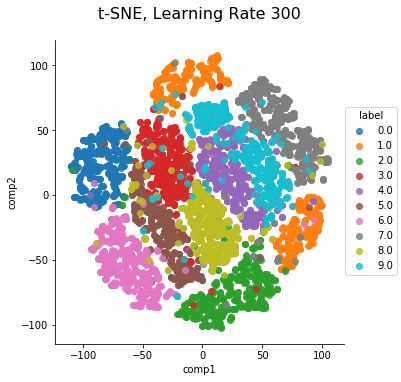

In [30]:
sns.lmplot(x='comp1', y='comp2', data=df_tsne5lr300, hue='label', fit_reg=False)
plt.title("t-SNE, Learning Rate 300", size=16, y=1.05)

Changes in the learning rate don't seem to make much of a difference. Clustering for each seems to be pretty constant, so I'll stick with my initial learning rate of 200 and try changes in the number of iterations. Again, I'll try increasing (1500) and decreasing (250 and 500) the number of iterations:

In [31]:
tsne5n250 = TSNE(n_components=2, verbose=1, perplexity=5, n_iter=250, learning_rate=200)
tsne5n250_results = tsne5n250.fit_transform(X_pca36[rows[:5000],:])

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.127s...
[t-SNE] Computed neighbors for 5000 samples in 38.133s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 1.101767
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.668617
[t-SNE] Error after 251 iterations: 179769313486231570814527423731704356798070567525844996598917476803157260780028538760589558632766878171540458953514382464234321326889464182768467546703537516986049910576551282076245490090389328944075868508455133942304583236903222948165808559332123348274797826204144723168738177180919299881250404026184124858368.000000


In [32]:
df_tsne5n250 = pd.DataFrame(tsne5n250_results, columns=['comp1', 'comp2'])
df_tsne5n250['label'] = y[rows[:5000]]

Text(0.5,1.05,'t-SNE, 250 Iterations')

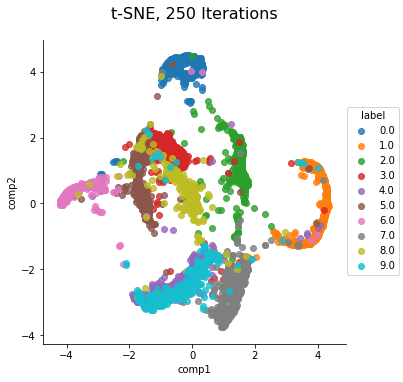

In [33]:
sns.lmplot(x='comp1', y='comp2', data=df_tsne5n250, hue='label', fit_reg=False)
plt.title("t-SNE, 250 Iterations", size=16, y=1.05)

In [34]:
tsne5n500 = TSNE(n_components=2, verbose=1, perplexity=5, n_iter=500, learning_rate=200)
tsne5n500_results = tsne5n500.fit_transform(X_pca36[rows[:5000],:])

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.124s...
[t-SNE] Computed neighbors for 5000 samples in 38.321s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 1.101767
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.534004
[t-SNE] Error after 500 iterations: 1.892337


In [35]:
df_tsne5n500 = pd.DataFrame(tsne5n500_results, columns=['comp1', 'comp2'])
df_tsne5n500['label'] = y[rows[:5000]]

Text(0.5,1.05,'t-SNE, 500 Iterations')

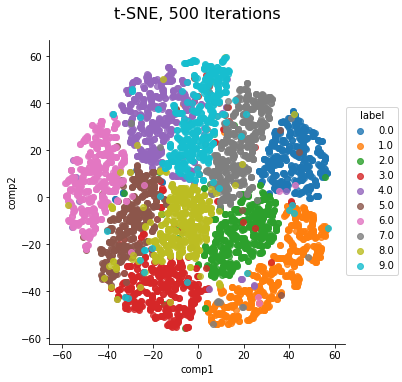

In [36]:
sns.lmplot(x='comp1', y='comp2', data=df_tsne5n500, hue='label', fit_reg=False)
plt.title("t-SNE, 500 Iterations", size=16, y=1.05)

In [37]:
tsne5n1500 = TSNE(n_components=2, verbose=1, perplexity=5, n_iter=1500, learning_rate=200)
tsne5n1500_results = tsne5n1500.fit_transform(X_pca36[rows[:5000],:])

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.134s...
[t-SNE] Computed neighbors for 5000 samples in 38.235s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 1.101767
[t-SNE] KL divergence after 250 iterations with early exaggeration: 88.743095
[t-SNE] Error after 1500 iterations: 1.448448


In [38]:
df_tsne5n1500 = pd.DataFrame(tsne5n1500_results, columns=['comp1', 'comp2'])
df_tsne5n1500['label'] = y[rows[:5000]]

Text(0.5,1.05,'t-SNE, 1500 Iterations')

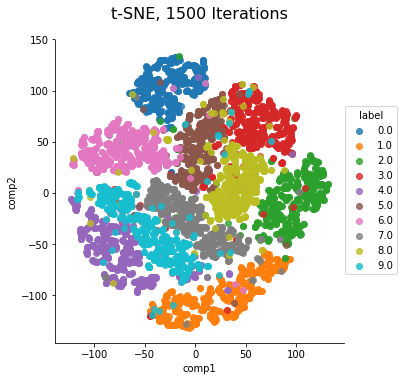

In [39]:
sns.lmplot(x='comp1', y='comp2', data=df_tsne5n1500, hue='label', fit_reg=False)
plt.title("t-SNE, 1500 Iterations", size=16, y=1.05)

250 iterations seems to be far too few: the divisions in the data seem to have not really stabilized at that point, and the clustering isn't quite how it should be. 500 iterations doesn't seem to cause much of a difference. While 1500 iterations separates most of the clusters out quite nicely, it also separates the 1's into 3 different clusters, which could be problematic if I were using t-SNE to go over unlabeled data.

Overall, I'd say t-SNE was pretty robust to learning rate and was mostly robust to number of iterations. Number of iterations caused a couple of changes, and in more serious use it'd be worth paying attention to that.

### 3) K-Means Clustering

Clustering is a form of unsupervised machine learning algorithm that attempts to identify similar data without being given a label. This can be enormously useful since it circumvents the need for labels on the data, but it also can be pretty finicky and difficult to get working well.

#### a) Choosing the number of clusters

In most projects, the number of clusters is something you'd want to spend a lot of time thinking about, since it won't always be apparent what a good number will be. In this case, since I'll be using K-Means clustering for the MNIST dataset, I'll have 10 clusters: one for each integer included in MNIST.

Running the K-Means algorithm over the MNIST data and predicting clusters:

In [40]:
kmeans = KMeans(n_clusters=10)
kmeans.fit(X[rows[:5000],:])
clusters = kmeans.predict(X[rows[:5000],:])

#### b) Evaluating K-Means Clustering

Without labeled data, it can be pretty difficult to gauge the efficacy of K-Means clustering, but with labeled data, it's trivial to check it against the labeled data. Here I use a number of comparisons to judge its effectiveness:

In [41]:
print("Adjusted Rand Index:\t", adjusted_rand_score(clusters, y[rows[:5000]]))
print("Homogeneity:\t\t", homogeneity_score(clusters, y[rows[:5000]]))
print("Completeness:\t\t", completeness_score(clusters, y[rows[:5000]]))
print("V-Measure:\t\t", v_measure_score(clusters, y[rows[:5000]]))

Adjusted Rand Index:	 0.372839987429
Homogeneity:		 0.502495050989
Completeness:		 0.498678359653
V-Measure:		 0.500579430292


The Adjusted Rand Index is a measure of how similar the predictions are to the actual labels, and ignores permutations and chance normalization. Homogeneity measures whether each cluster only contains members of a single class. Completeness measures whether all members of the same class are assigned to the same cluster. V-Measure is the harmonic mean of completeness and homogeneity. In all cases, a score closer to 1 indicates a better classifier, while a score close to 0 indicates a poor classifier.

It looks like the K-Means classifier didn't do too well on any of the counts, which is largely to be expected from an unsupervised model.

#### c) Visualizing K-Means Clustering using t-SNE

T-SNE can be used to visualize how well the predictions from K-Means Clustering corresponded to actual clusters. I'll use the best t-SNE parameters that I found in part 2:

Text(0.5,1.05,'K-Means Clustering Predictions')

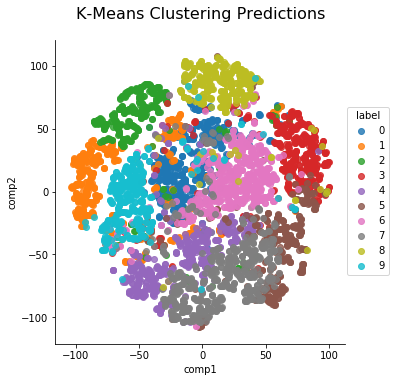

In [42]:
df_tsne_clusters = pd.DataFrame(tsne5_results, columns=['comp1', 'comp2'])
df_tsne_clusters['label'] = clusters

sns.lmplot(x='comp1', y='comp2', data=df_tsne_clusters, hue='label', fit_reg=False)
plt.title("K-Means Clustering Predictions", size=16, y=1.05)

Text(0.5,1.05,'Actual Clusters')

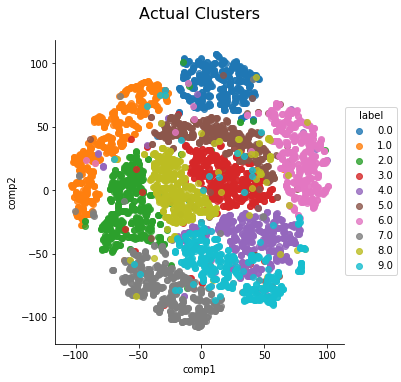

In [43]:
sns.lmplot(x='comp1', y='comp2', data=df_tsne5, hue='label', fit_reg=False)
plt.title("Actual Clusters", size=16, y=1.05)

From the visualization, it's pretty apparent that K-Means Clustering hasn't done too well. Many of the actual clusters were split by K-means, and lots of the clusters found by K-means are actually mixes of the true categories. This was to be expected, given how poorly K-means performed on the measures we used for evaluation above.

#### d) Scaling Data

K-means often works better with scaled data, but in this instance, I didn't scale the data since it had already been scaled when I imported the MNIST dataset. Values for pixels in the MNIST dataset range from 0 to 255, which I divided by 255 to get a range from 0 to 1.

#### e) How robust is clustering?

Clustering can have a tendency to overfit to the data used to train it. Thankfully, since I only used a portion of the MNIST dataset to train my previous K-Means model, I can check for robustness by checking how well that model performs on other portions of the MNIST dataset. I tested it on two other subsets of the MNIST dataset it wasn't trained on:

In [44]:
clusters = kmeans.predict(X[rows[5000:10000],:])

print("Adjusted Rand Index:\t", adjusted_rand_score(clusters, y[rows[5000:10000]]))
print("Homogeneity:\t\t", homogeneity_score(clusters, y[rows[5000:10000]]))
print("Completeness:\t\t", completeness_score(clusters, y[rows[5000:10000]]))
print("V-Measure:\t\t", v_measure_score(clusters, y[rows[5000:10000]]))

Adjusted Rand Index:	 0.370874244995
Homogeneity:		 0.494536891994
Completeness:		 0.491569484356
V-Measure:		 0.493048723389


In [45]:
clusters = kmeans.predict(X[rows[10000:15000],:])

print("Adjusted Rand Index:\t", adjusted_rand_score(clusters, y[rows[10000:15000]]))
print("Homogeneity:\t\t", homogeneity_score(clusters, y[rows[10000:15000]]))
print("Completeness:\t\t", completeness_score(clusters, y[rows[10000:15000]]))
print("V-Measure:\t\t", v_measure_score(clusters, y[rows[10000:15000]]))

Adjusted Rand Index:	 0.368948544683
Homogeneity:		 0.49369430279
Completeness:		 0.49079076245
V-Measure:		 0.492238250916


In both cases, the values on every measure of accuracy were nearly the same, within just a few percent of each other. In fact, the clustering actually performed better on the test data, all of which indicates that it didn't overfit to the data it was trained on. While K-Means Clustering often isn't robust, in this case it seemed to handle the added tests pretty well and the clustering seems fairly robust, albeit none too accurate.

### 4) Hierarchical Clustering

Hierarchical clustering is another method used for finding clusters in unlabeled data, and has the added advantage that it doesn't require you to assume the number of clusters that are present in the data.

#### a) Plotting Dendrograms

Set up the model used in clustering, and plot the corresponding dendrogram:

In [46]:
complete = linkage(X[rows[:5000],:], 'complete')

([], <a list of 0 Text yticklabel objects>)

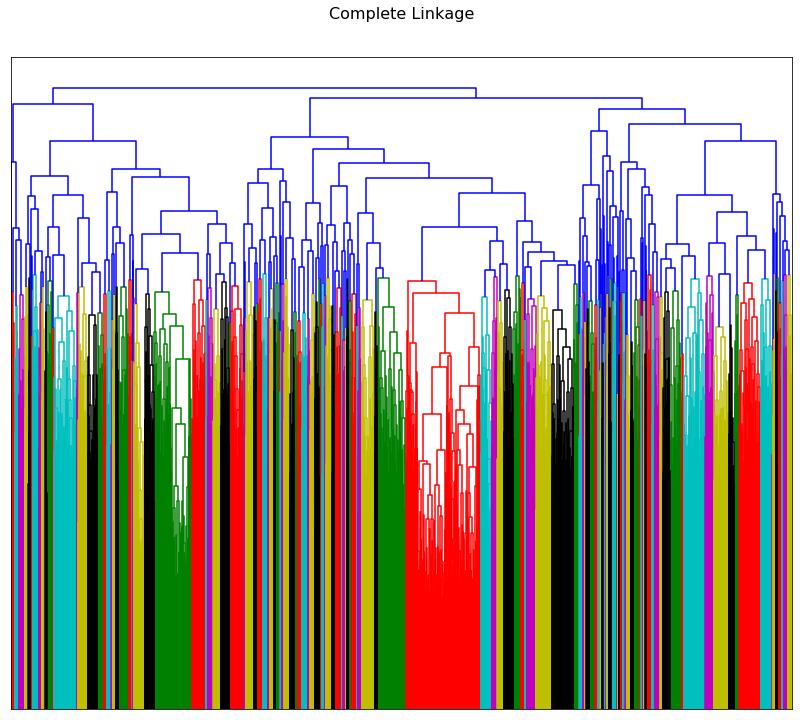

In [47]:
plt.figure(figsize=(14,12))
dg_complete = dendrogram(complete)

plt.title("Complete Linkage", size=16, y=1.05)
plt.xticks([])
plt.yticks([])

The dendrogram is pretty messy, but it can be used to find clusters in the data. It doesn't seem to be working to well on the MNIST data; there should be 10 relatively clear divisions that only connect at a higher level, but there aren't really clear places where different integers might be.

#### b) Number of clusters?

It's really hard to tell from the dendrogram above. There should be 10 clusters, but that isn't really visible in the above dendrogram. There are four divisions that are relatively high in the dendrogram, but it hasn't done well enough for it to serve as a good measure of the number of clusters in the data. Anywhere from 3 to 15 divisions could be reasonable given the dendrogram above.

#### c) Different Linkage Methods

In the hierarchical clustering above, I used complete linking, but there are a number of different linking methods that can be used. I'll try two others, average and weighted, and chart their dendrograms to see how they compare.

In [48]:
average = linkage(X[rows[:5000],:], 'average')

([], <a list of 0 Text yticklabel objects>)

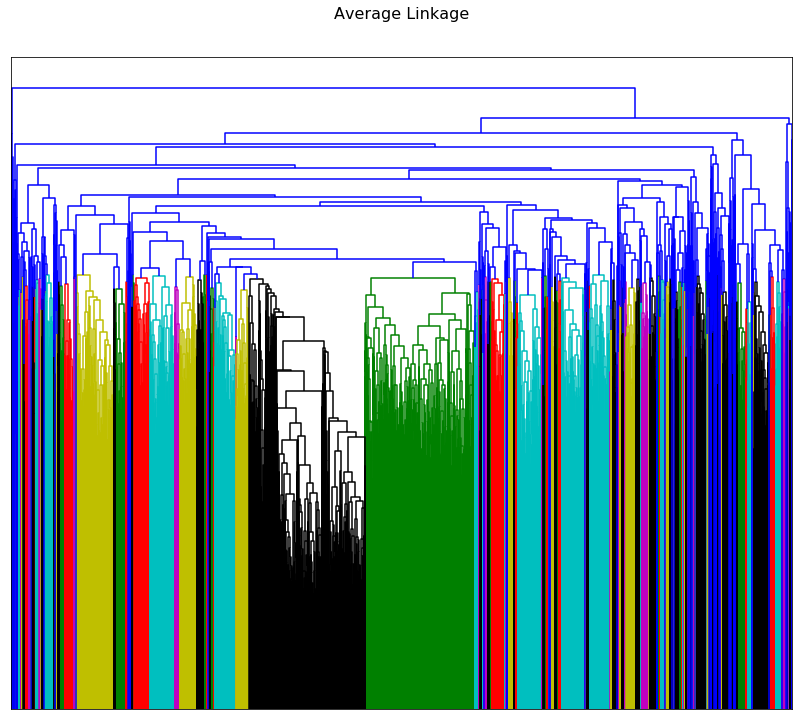

In [49]:
plt.figure(figsize=(14,12))
dg_average = dendrogram(average)

plt.title("Average Linkage", size=16, y=1.05)
plt.xticks([])
plt.yticks([])

In [50]:
weighted = linkage(X[rows[:5000],:], 'weighted')

([], <a list of 0 Text yticklabel objects>)

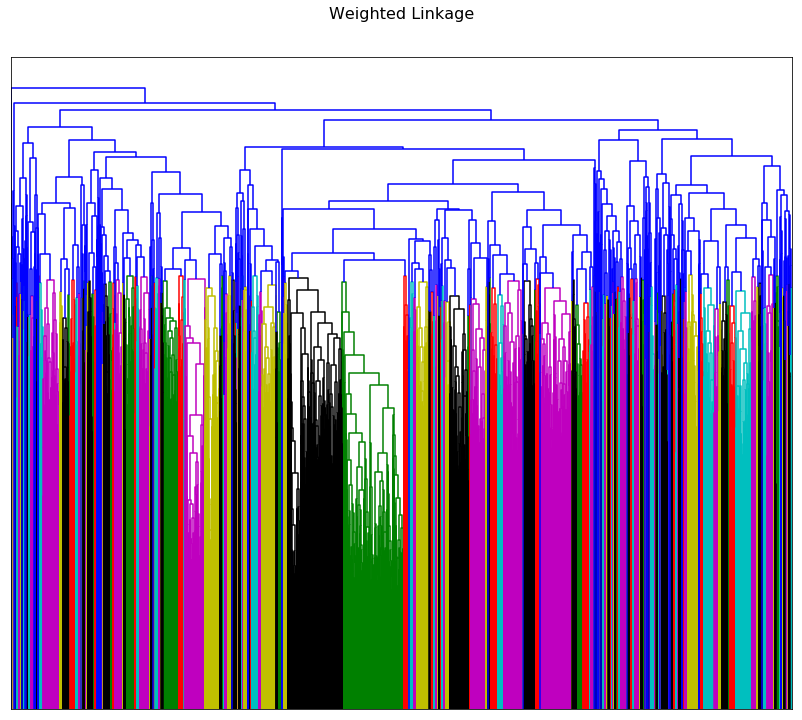

In [51]:
plt.figure(figsize=(14,12))
dg_weighted = dendrogram(weighted)

plt.title("Weighted Linkage", size=16, y=1.05)
plt.xticks([])
plt.yticks([])

In all honesty, I'm not very good at reading dendrograms, but using weighted linkage seems to give a pretty good estimate of clusters. Again, I'd be hard pressed to identify 10 clusters in there, but it does seem to get close with the number of clusters that connect at the top, though I'm not sure if it's any improvement on complete linkage.

While it can be enormously useful in some instances, hierarchical clustering doesn't seem to be particularly well-suited to identifying clusters in the MNIST dataset.

While it probably makes the most sense to analyze the MNIST dataset using supervised machine learning techniques, applying unsupervised techniques to a dataset with labels allows for better analysis of how the categorization has done. More directly, dimensionality reduction techniques proved very usable for identifying the most important dimensions in the images, allowing for compression and more accurate visualizations of clusters present in the data.